In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

D:\Users\Yue\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.path.append("..")
from optimizer import NormalizedOptimizer
from utils import callbacks

Using TensorFlow backend.


In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

In [5]:
sess = tf.InteractiveSession()
K.set_session(sess)

# Code from [kmkolasinski/deep-learning-notes](https://github.com/kmkolasinski/deep-learning-notes/blob/master/max-normed-optimizer/notebooks/Keras_CNN_CIFAR10_test.ipynb)

# Dataset Loading

In [6]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [7]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Model Definition

In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.regularizers import l2

In [9]:
def generate_model():
    ip = Input(shape=(32, 32, 3))
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(ip)
    x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(ip, x)
    return model

In [10]:
BATCHSIZE = 128

In [30]:
generate_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        36928     
__________

# Train with Normalized SGD

In [11]:
model = generate_model()
metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.005, 0.001, 0.0001]: 
    optimizer = NormalizedOptimizer(SGD(lr, momentum=0.9, nesterov=True), normalization='l2')
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=15, 
        validation_data=(x_test, y_test), 
        callbacks=metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 307us/step - loss: 1.9278 - acc: 0.2876 - val_loss: 1.6225 - val_acc: 0.4031
Epoch 2/15
50000/50000 [==============================] - 13s 258us/step - loss: 1.5910 - acc: 0.4174 - val_loss: 1.3791 - val_acc: 0.5027
Epoch 3/15
50000/50000 [==============================] - 13s 259us/step - loss: 1.4205 - acc: 0.4857 - val_loss: 1.2423 - val_acc: 0.5521
Epoch 4/15
50000/50000 [==============================] - 13s 257us/step - loss: 1.3101 - acc: 0.5265 - val_loss: 1.1705 - val_acc: 0.5813
Epoch 5/15
50000/50000 [==============================] - 13s 257us/step - loss: 1.2210 - acc: 0.5638 - val_loss: 1.1363 - val_acc: 0.5973
Epoch 6/15
50000/50000 [==============================] - 13s 256us/step - loss: 1.1518 - acc: 0.5908 - val_loss: 1.0257 - val_acc: 0.6374
Epoch 7/15
50000/50000 [==============================] - 13s 257us/step - loss: 1.0884 - acc: 0.6141 - val_loss: 0.

50000/50000 [==============================] - 13s 254us/step - loss: 0.4848 - acc: 0.8271 - val_loss: 0.5959 - val_acc: 0.7931
Epoch 12/15
50000/50000 [==============================] - 13s 254us/step - loss: 0.4951 - acc: 0.8215 - val_loss: 0.5966 - val_acc: 0.7933
Epoch 13/15
50000/50000 [==============================] - 13s 253us/step - loss: 0.4926 - acc: 0.8238 - val_loss: 0.5959 - val_acc: 0.7934
Epoch 14/15
50000/50000 [==============================] - 13s 252us/step - loss: 0.4896 - acc: 0.8236 - val_loss: 0.5940 - val_acc: 0.7939ETA: 10s - loss: 0.4800 - acc: 0.8311 - ETA: 7s - loss: 0.4852 - acc: 0.8255
Epoch 15/15
50000/50000 [==============================] - 13s 252us/step - loss: 0.4927 - acc: 0.8239 - val_loss: 0.5953 - val_acc: 0.7954


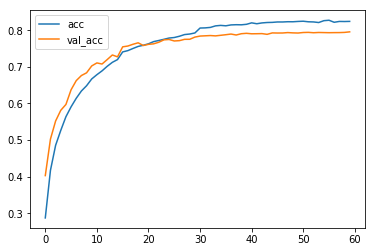

In [12]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Train with Normalized Adam

In [26]:
model = generate_model()
adam_metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001]: 
    optimizer = NormalizedOptimizer(Adam(lr), normalization='l2')
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=15, 
        validation_data=(x_test, y_test), 
        callbacks=adam_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 16s 327us/step - loss: 1.6108 - acc: 0.4097 - val_loss: 1.2585 - val_acc: 0.5479
Epoch 2/15
50000/50000 [==============================] - 14s 279us/step - loss: 1.2141 - acc: 0.5698 - val_loss: 1.0136 - val_acc: 0.6458
Epoch 3/15
50000/50000 [==============================] - 14s 279us/step - loss: 1.0425 - acc: 0.6320 - val_loss: 0.9356 - val_acc: 0.6715ETA: 9s - loss: 1.0803 - acc: 0.6186 - ETA: 6s - loss: 1.0696 - acc: 0.6212
Epoch 4/15
50000/50000 [==============================] - 14s 279us/step - loss: 0.9273 - acc: 0.6736 - val_loss: 0.8594 - val_acc: 0.7005
Epoch 5/15
50000/50000 [==============================] - 14s 280us/step - loss: 0.8485 - acc: 0.7037 - val_loss: 0.7954 - val_acc: 0.7225
Epoch 6/15
50000/50000 [==============================] - 14s 280us/step - loss: 0.7777 - acc: 0.7288 - val_loss: 0.7406 - val_acc: 0.7443
Epoch 7/15
50000/50000 [=================

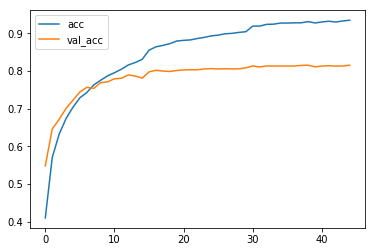

In [36]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Train with Adam

In [38]:
model = generate_model()
amsgrad_metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001]: 
    optimizer = Adam(lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=15, 
        validation_data=(x_test, y_test), 
        callbacks=amsgrad_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 18s 351us/step - loss: 1.6170 - acc: 0.4073 - val_loss: 1.2188 - val_acc: 0.5638
Epoch 2/15
50000/50000 [==============================] - 14s 281us/step - loss: 1.1937 - acc: 0.5711 - val_loss: 0.9935 - val_acc: 0.6473
Epoch 3/15
50000/50000 [==============================] - 14s 280us/step - loss: 1.0177 - acc: 0.6411 - val_loss: 0.8659 - val_acc: 0.6990
Epoch 4/15
50000/50000 [==============================] - 14s 279us/step - loss: 0.9038 - acc: 0.6821 - val_loss: 0.8051 - val_acc: 0.7171
Epoch 5/15
50000/50000 [==============================] - 14s 279us/step - loss: 0.8345 - acc: 0.7063 - val_loss: 0.8595 - val_acc: 0.7102
Epoch 6/15
50000/50000 [==============================] - 14s 280us/step - loss: 0.7729 - acc: 0.7290 - val_loss: 0.7193 - val_acc: 0.7500
Epoch 7/15
50000/50000 [==============================] - 14s 280us/step - loss: 0.7272 - acc: 0.7454 - val_loss: 0.

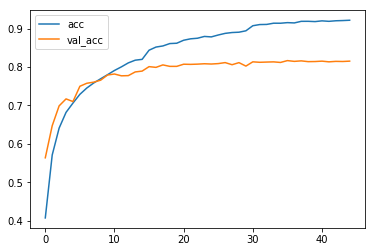

In [40]:
hist = amsgrad_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

In [41]:
from collections import OrderedDict
hists = OrderedDict()
hists['NSGD'] = metrics_history
hists['NADAM'] = adam_metrics_history
hists['Adam'] = amsgrad_metrics_history

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

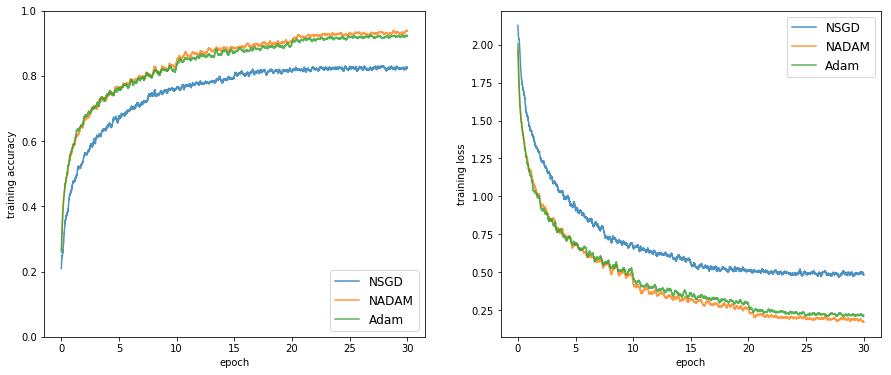

In [42]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training loss')

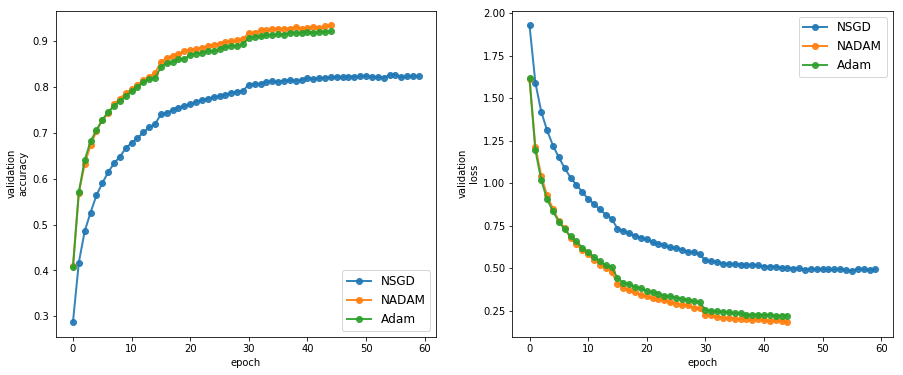

In [44]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['acc']
    plt.plot(h, 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['loss']
    plt.plot(h, 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')